# Read the files

In [60]:
library("tidyverse")
library("janitor")
library("caret")
library("mlr")

Loading required package: ParamHelpers

Attaching package: ‘mlr’

The following object is masked from ‘package:caret’:

    train



In [61]:
df_train = readRDS("df_train_after_03FE.RData")
df_val = readRDS("df_val_after_03FE.RData")
cols_with_low_iv_values = readRDS("cols_with_low_iv_values.RData")
cols_with_woe_added = readRDS("cols_with_woe_added.RData")

In [62]:
head(df_train,2)

t_date,t_mo,t_day,t_qtr,t_wk,t_day_of_yr,t_day_of_wk,t_day_of_wk_name,t_eval_day,t_eval_wk,⋯,wea_ohare_tavg2_ma60_lag7,woe_t_mo,woe_t_qtr,woe_t_day_of_wk_name,woe_trap_trap_name,woe_loc_zipcode,woe_loc_census_block_group_id,woe_loc_census_tract_id,woe_loc_community,woe_zone_class
2007-05-29,May,29,Q2,22,149,2,Mon,514,74,⋯,53.175,0,-3.422749,-0.006350824,0.6376936,0.4050713,0.6376936,0.6376936,0.4155262,0.2412784
2007-05-29,May,29,Q2,22,149,2,Mon,514,74,⋯,53.175,0,-3.422749,-0.006350824,0.0000000,0.4093463,-0.2377751,0.3716731,0.2198060,-0.2392755


In [63]:
dim(df_train)

[1] 8222   59

In [64]:
cols_with_low_iv_values %>% cat(sep = " :: ")

ses_median_hh_inc_tract2017 :: ses_lt_hs_pct_blk_grp2017 :: ses_lt_pov_pct_blk_grp2017 :: ses_lt_hs_pct_tract2017 :: nbrhud_comm_180d_violation_cnt :: ses_median_hh_inc_blk_grp2017 :: zone_type :: nbrhud_blk_grp_180d_violation_cnt :: loc_lat_lng_src :: nbrhud_zipcode_180d_violation_cnt :: wea_ohare_tavg2 :: mos_unspecified_num_mosquitos :: trap_trap_type :: mos_erraticus_num_mosquitos :: mos_tarsalis_num_mosquitos :: mos_salinarius_num_mosquitos :: trap_satellite_ind :: nbrhud_blk_grp_180d_vacancies_cnt :: mos_territans_num_mosquitos :: nbrhud_comm_180d_vacancies_cnt :: nbrhud_zipcode_180d_vacancies_cnt :: mos_restuans_num_mosquitos :: wea_ohare_prcp :: t_day

# Little cleanup

In [65]:
# Remove cols_with_low_iv_values to make life a bit simplier

df_train = df_train %>% select(-cols_with_low_iv_values)
df_val = df_val %>% select(-cols_with_low_iv_values)

In [66]:
dim(df_train)

[1] 8222   35

In [67]:
dim(df_val)

[1] 3430   35

In [68]:
glimpse(df_train)

Observations: 8,222
Variables: 35
$ t_date                             <date> 2007-05-29, 2007-05-29, 2007-05...
$ t_mo                               <fct> May, May, May, May, May, May, Ma...
$ t_qtr                              <fct> Q2, Q2, Q2, Q2, Q2, Q2, Q2, Q2, ...
$ t_wk                               <int> 22, 22, 22, 22, 22, 22, 22, 22, ...
$ t_day_of_yr                        <int> 149, 149, 149, 149, 149, 149, 14...
$ t_day_of_wk                        <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...
$ t_day_of_wk_name                   <fct> Mon, Mon, Mon, Mon, Mon, Mon, Mo...
$ t_eval_day                         <int> 514, 514, 514, 514, 514, 514, 51...
$ t_eval_wk                          <int> 74, 74, 74, 74, 74, 74, 74, 74, ...
$ trap_trap_name                     <fct> T002, T007, T015, T045, T046, T0...
$ loc_lat                            <dbl> 41.95630, 41.99549, 41.97418, 41...
$ loc_lng                            <dbl> -87.79752, -87.76961, -87.82524,...
$ loc_zipcode     

In [69]:
response = "mos_any_wnv_present"
predictors = df_train %>% select(-response,-t_date, -cols_with_woe_added) %>% names

# Model Setup

In [49]:
library("randomForest")
?randomForest.formula

randomForest {randomForest},R Documentation
data,an optional data frame containing the variables in the model. By default the variables are taken from the environment which randomForest is called from.
subset,"an index vector indicating which rows should be used. (NOTE: If given, this argument must be named.)"
na.action,"A function to specify the action to be taken if NAs are found. (NOTE: If given, this argument must be named.)"
"x, formula","a data frame or a matrix of predictors, or a formula describing the model to be fitted (for the print method, an randomForest object)."
y,"A response vector. If a factor, classification is assumed, otherwise regression is assumed. If omitted, randomForest will run in unsupervised mode."
xtest,a data frame or matrix (like x) containing predictors for the test set.
ytest,response for the test set.
ntree,"Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times."
mtry,Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p/3)
replace,Should sampling of cases be done with or without replacement?


In [57]:
rfFit = randomForest(df_train[,predictors],as.factor(df_train[[response]]),importance=TRUE,mtry = 5)

In [58]:
rfFit


Call:
 randomForest(x = df_train[, predictors], y = as.factor(df_train[[response]]),      mtry = 5, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 7.76%
Confusion matrix:
     0   1 class.error
0 7304 132  0.01775148
1  506 280  0.64376590

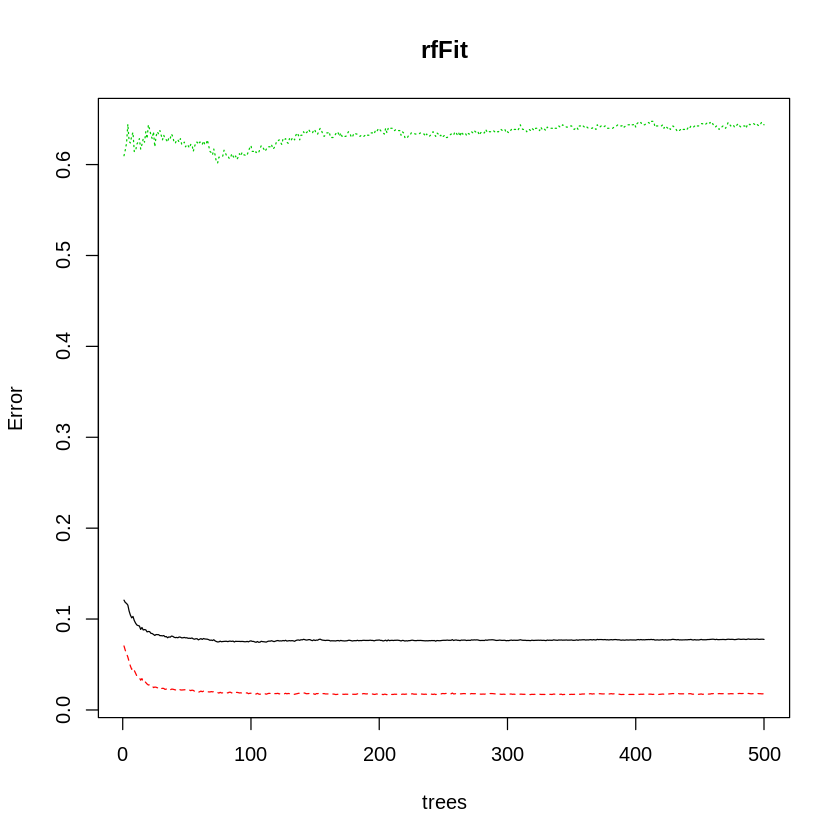

In [59]:
plot(rfFit)

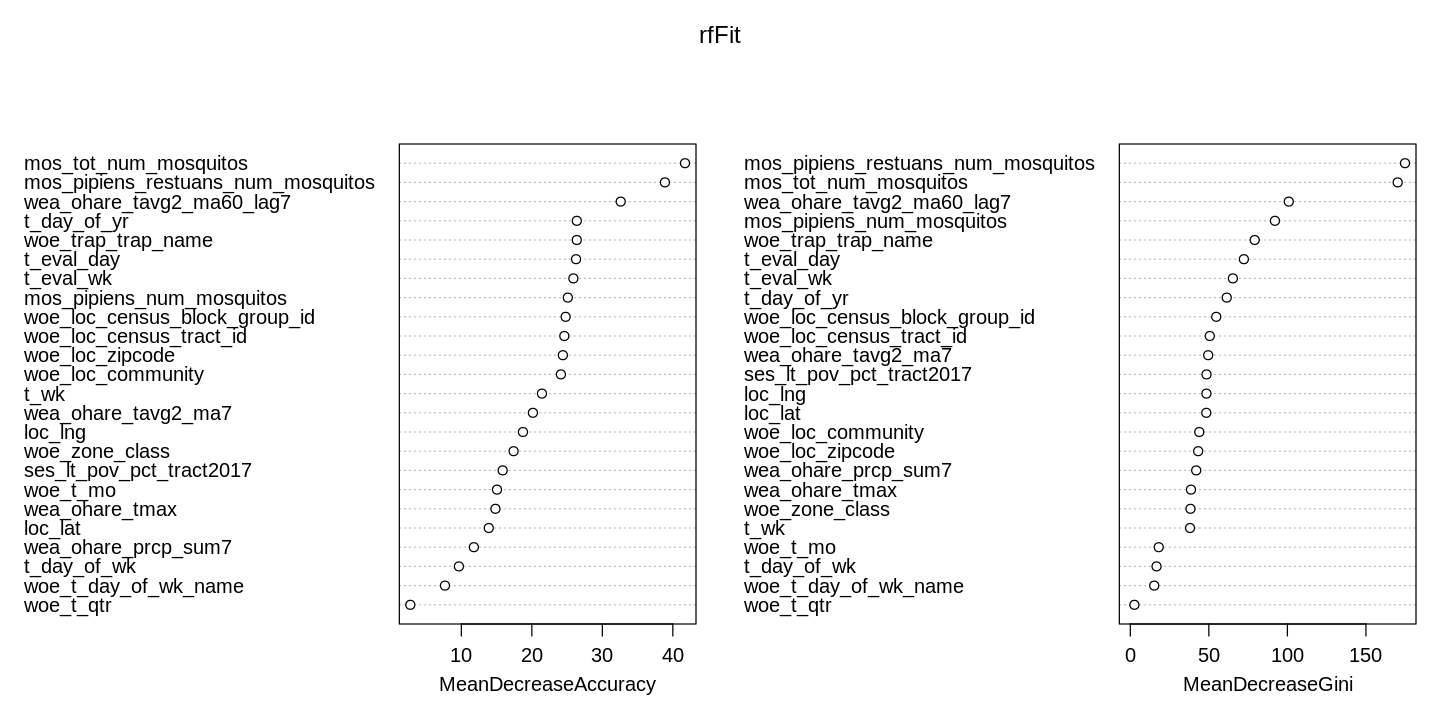

In [92]:
options(repr.plot.width=12, repr.plot.height=6)
randomForest::varImpPlot(rfFit)

In [70]:
library("xgboost")


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



In [83]:
xgbFit = xgboost(data = as.matrix(df_train[,predictors]), label = as.numeric(df_train[[response]]), nrounds = 300, verbose = T)

[1]	train-rmse:0.386981 
[2]	train-rmse:0.315425 
[3]	train-rmse:0.271500 
[4]	train-rmse:0.243556 
[5]	train-rmse:0.226177 
[6]	train-rmse:0.214824 
[7]	train-rmse:0.207252 
[8]	train-rmse:0.202825 
[9]	train-rmse:0.199597 
[10]	train-rmse:0.197431 
[11]	train-rmse:0.193222 
[12]	train-rmse:0.190077 
[13]	train-rmse:0.188103 
[14]	train-rmse:0.185922 
[15]	train-rmse:0.185346 
[16]	train-rmse:0.182420 
[17]	train-rmse:0.180617 
[18]	train-rmse:0.179964 
[19]	train-rmse:0.178486 
[20]	train-rmse:0.177044 
[21]	train-rmse:0.176338 
[22]	train-rmse:0.173867 
[23]	train-rmse:0.172509 
[24]	train-rmse:0.170333 
[25]	train-rmse:0.168771 
[26]	train-rmse:0.167419 
[27]	train-rmse:0.164630 
[28]	train-rmse:0.163710 
[29]	train-rmse:0.162525 
[30]	train-rmse:0.161629 
[31]	train-rmse:0.161533 
[32]	train-rmse:0.160698 
[33]	train-rmse:0.158490 
[34]	train-rmse:0.157341 
[35]	train-rmse:0.155731 
[36]	train-rmse:0.154397 
[37]	train-rmse:0.153550 
[38]	train-rmse:0.152099 
[39]	train-rmse:0.149

In [84]:
xgbFit

##### xgb.Booster
raw: 1.1 Mb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks)
params (as set within xgb.train):
  silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 24 
niter: 300
nfeatures : 24 
evaluation_log:
    iter train_rmse
       1   0.386981
       2   0.315425
---                
     299   0.028081
     300   0.027933

In [85]:
xgboost::xgb.importance(xgbFit)

ERROR: Error in xgboost::xgb.importance(xgbFit): model: must be an object of class xgb.Booster


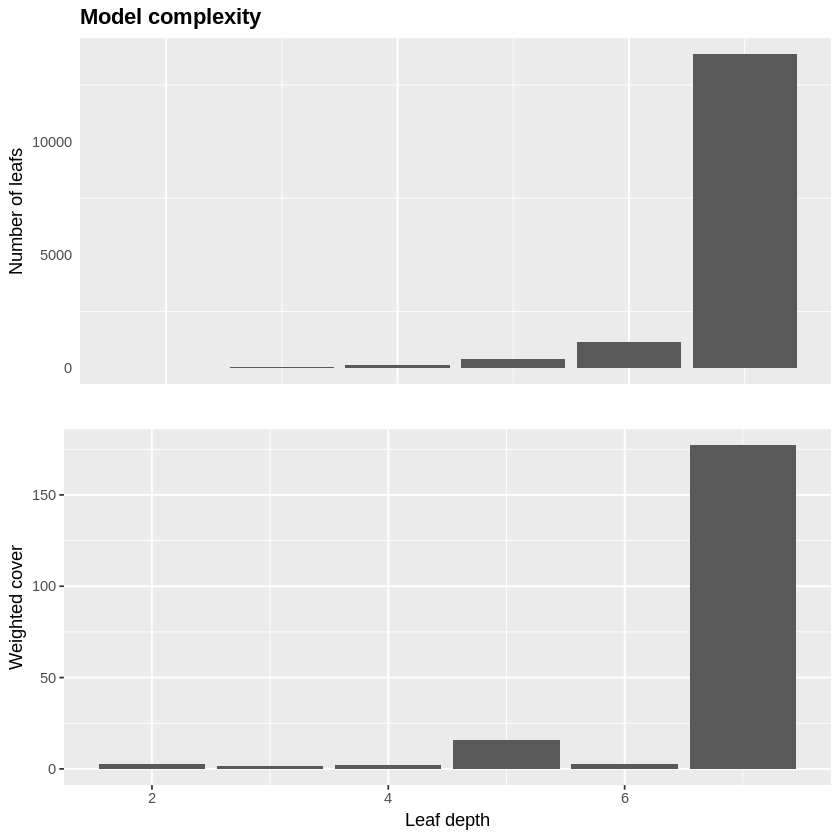

In [86]:
xgb.ggplot.deepness(model = xgbFit)